### **Import Libraries**

In [170]:
# Data Processing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Model Libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE


In [171]:
warnings.filterwarnings('ignore')

### **Load and Explore Dataset**

In [172]:
# Load CSV
df = pd.read_csv('/content/iris.csv')

# Quick look at the data
print(df.head())
print("\n", df["class"].value_counts())
print("\n")
print(df.info())

   sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

 class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


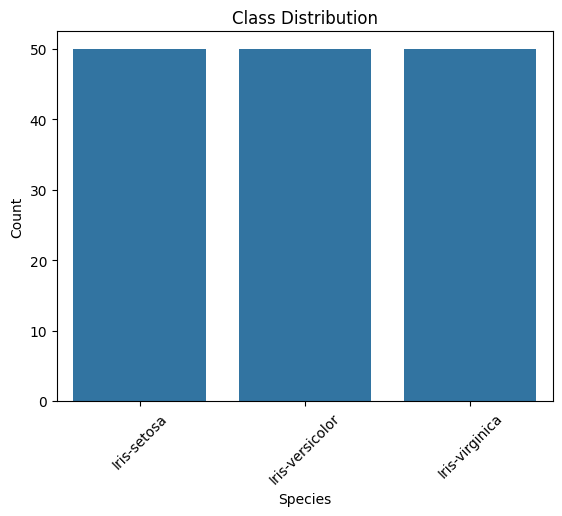

In [173]:
# Target class distribution plot

sns.countplot(data=df, x='class')
plt.title("Class Distribution")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

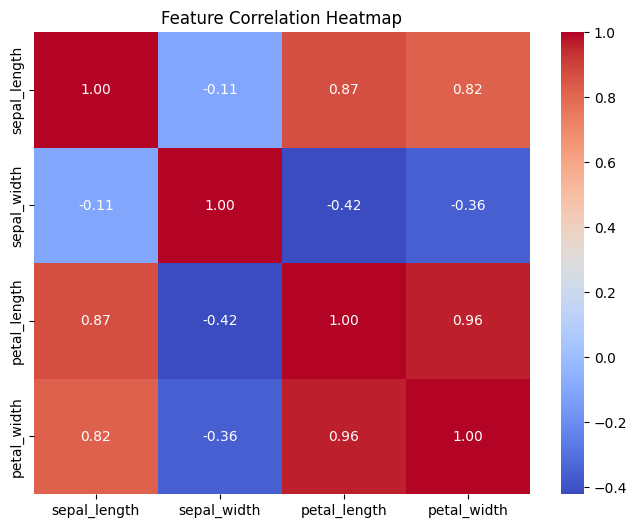

In [174]:
# Heatmap plot
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop('class', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

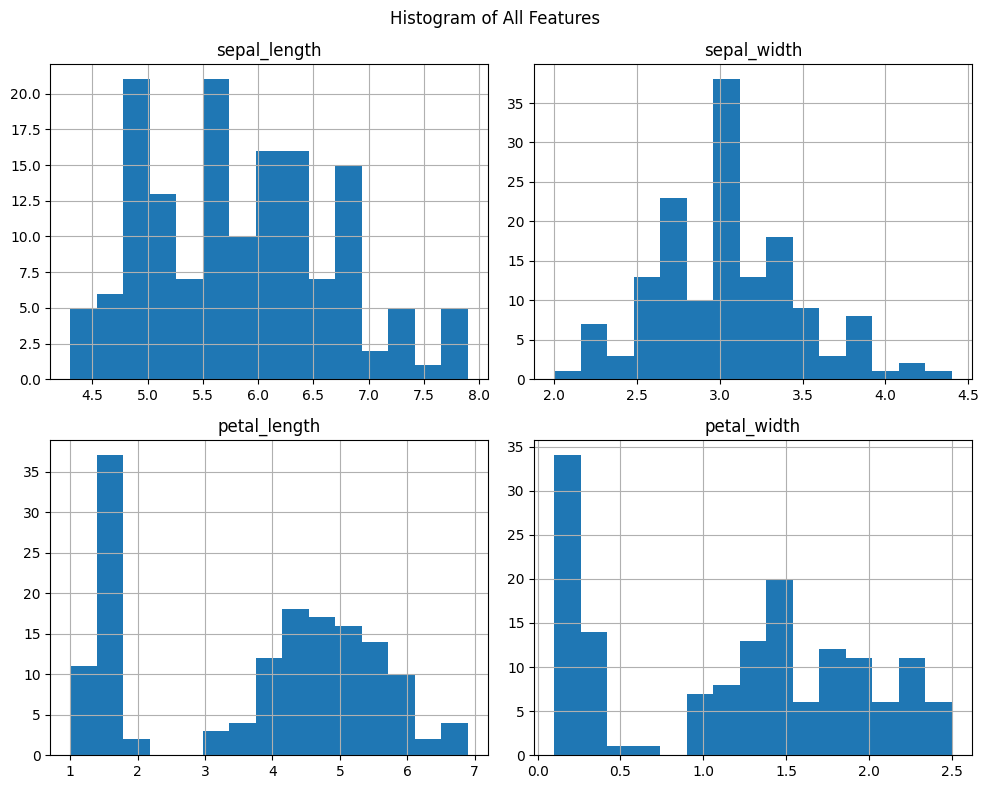

In [175]:
# Histogram of all features
df.hist(figsize=(10, 8), bins=15)
plt.suptitle("Histogram of All Features")
plt.tight_layout()
plt.show()


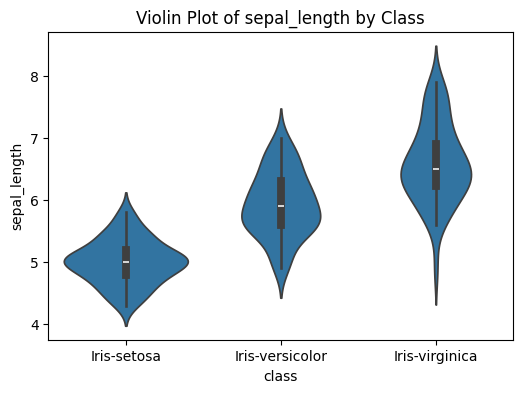

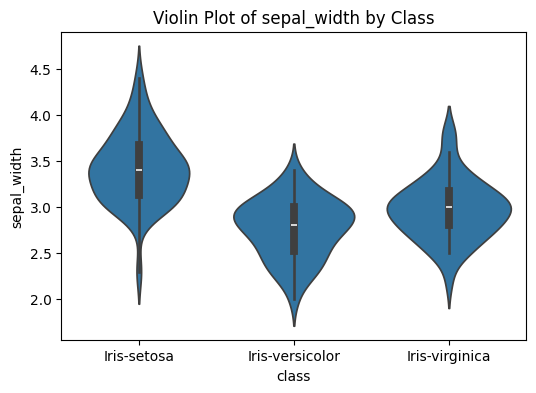

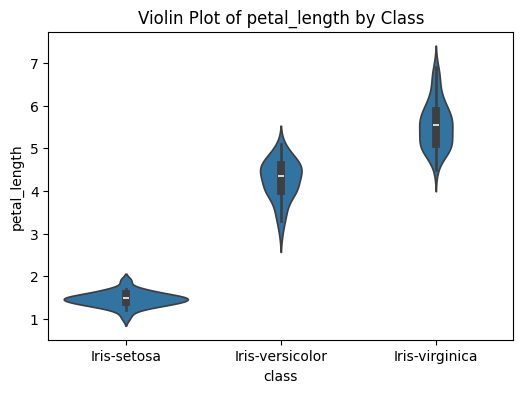

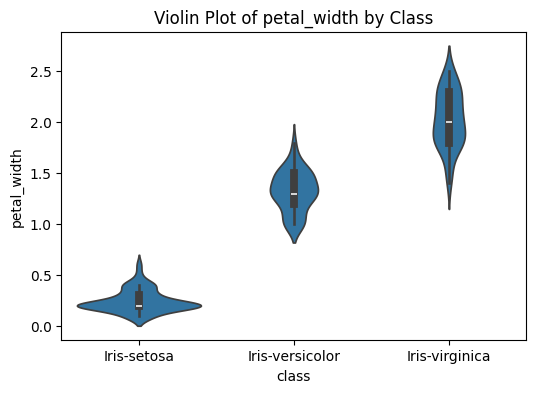

In [176]:
# Violin plot by class
for col in df.columns[:-1]:
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='class', y=col, data=df)
    plt.title(f'Violin Plot of {col} by Class')
    plt.show()


### **Preprocess the Data**

Dealing with Outliers

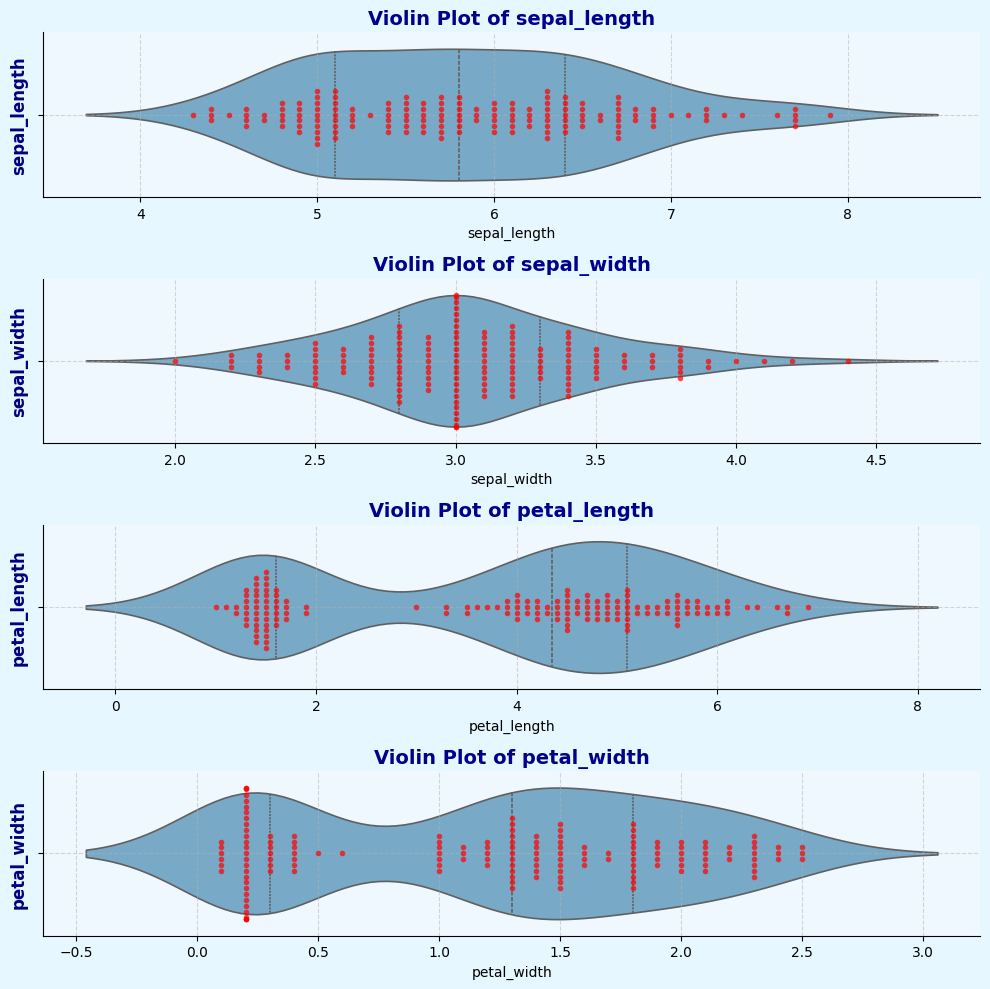

In [177]:
# Viloin plot for outliers detection

num_of_cols_without_target = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Set figure size dynamically
fig, axes = plt.subplots(nrows=len(num_of_cols_without_target), ncols=1, figsize=(10, len(num_of_cols_without_target) * 2.5), sharex=False)

# Set overall background color
fig.patch.set_facecolor('#E6F7FF')  # Light blue background

# Ensure axes is always iterable
if len(num_of_cols_without_target) == 1:
    axes = [axes]

# Loop through each feature and create a violin plot with swarmplot
for i, feature in enumerate(num_of_cols_without_target):
    sns.violinplot(x=df[feature], ax=axes[i], inner="quartile", palette="Blues", linewidth=1.2)

    # Overlay swarmplot to highlight individual points, especially outliers
    sns.swarmplot(x=df[feature], ax=axes[i], color="red", alpha=0.7, size=4)

    axes[i].set_ylabel(feature, fontsize=12, fontweight='bold', color='navy')
    axes[i].grid(True, linestyle="--", alpha=0.5)
    axes[i].set_facecolor("#F0F8FF")  # Light pastel background for subplots
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    # Add title
    axes[i].set_title(f'Violin Plot of {feature}', fontsize=14, fontweight="bold", color="darkblue")

# Adjust spacing
plt.tight_layout()
plt.show()

In [178]:
# Outlier detection and replacement using IQR
for col in ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median
    median_value = df[col].median()
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median_value, df[col])


**Preprocessing**

In [179]:
# Encode string class labels into integers
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(df["class"])

# One-hot encode the integer labels
y_encoded = to_categorical(y_int)

# Extract features
X = df.drop("class", axis=1).values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [180]:
# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Second split: Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Confirm shapes
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Training set: (105, 4)
Validation set: (22, 4)
Test set: (23, 4)


### **Feed-Forward Neural Network**

In [181]:

# Define FFNN model with more aggressive dropout
model_ffnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

"""
model_ffnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),  # increased from 0.2
    Dense(32, activation='relu'),
    Dropout(0.4),  # increased again
    Dense(3, activation='softmax')
])
"""

model_ffnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model (on original data now — not noisy)
history_ffnn = model_ffnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6302 - loss: 0.8350 - val_accuracy: 0.8182 - val_loss: 0.7254
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7620 - loss: 0.7437 - val_accuracy: 0.8182 - val_loss: 0.6227
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7182 - loss: 0.6749 - val_accuracy: 0.8182 - val_loss: 0.5494
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6958 - loss: 0.5943 - val_accuracy: 0.8636 - val_loss: 0.4939
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7380 - loss: 0.6012 - val_accuracy: 0.8636 - val_loss: 0.4506
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8007 - loss: 0.5145 - val_accuracy: 0.8182 - val_loss: 0.4186
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7042 - loss: 0.5511 - val_accuracy: 0.8636 - val_loss: 0.3929
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7933 - loss: 0.5236 - val_accuracy: 0.8636 - val

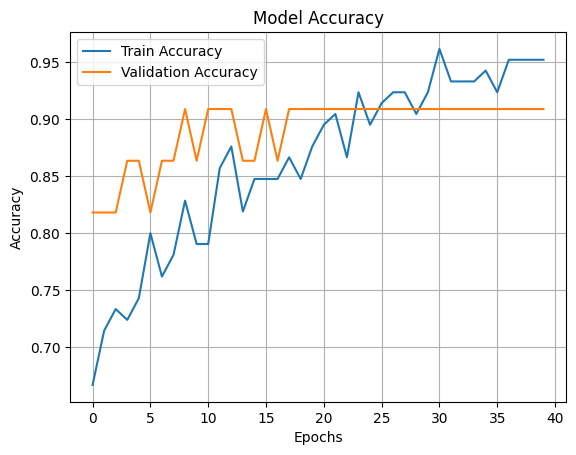

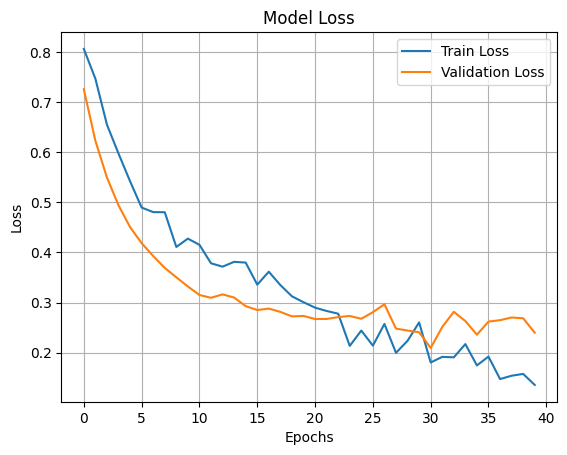

In [182]:
# Plot training vs validation accuracy
plt.plot(history_ffnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_ffnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training vs validation loss
plt.plot(history_ffnn.history['loss'], label='Train Loss')
plt.plot(history_ffnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Test Accuracy: 0.9130

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       1.00      0.75      0.86         8
 Iris-virginica       0.78      1.00      0.88         7

       accuracy                           0.91        23
      macro avg       0.93      0.92      0.91        23
   weighted avg       0.93      0.91      0.91        23



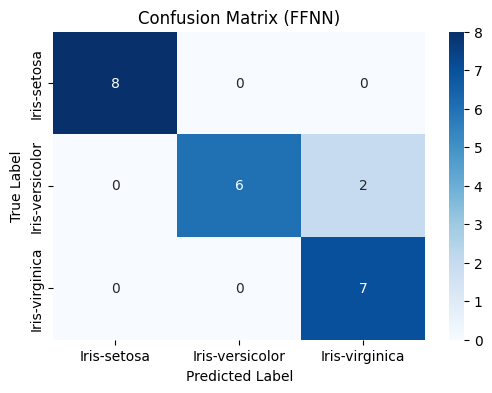

In [183]:
# Predict test set
y_pred_probs = model_ffnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report (Precision, Recall, F1-score)
target_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix (FFNN)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### **Auto-encoder + FFNN**

Auto-encoder

In [184]:
# Input layer
input_dim = X_train.shape[1]
encoding_dim = 2

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(3, activation='relu')(input_layer)
bottleneck = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(3, activation='relu')(bottleneck)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=90,
    batch_size=8,
    verbose=1
)



Epoch 1/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.9289 - val_loss: 1.1103
Epoch 2/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9576 - val_loss: 1.1074
Epoch 3/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9493 - val_loss: 1.1039
Epoch 4/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8981 - val_loss: 1.0999
Epoch 5/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8536 - val_loss: 1.0947
Epoch 6/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9222 - val_loss: 1.0892
Epoch 7/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9371 - val_loss: 1.0822
Epoch 8/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0009 - val_loss: 1.0752
Epoch 9/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8785 - val_loss: 1.0662
Epoch 10/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8829 - val_loss: 1.0572
Epoch 11/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8906 - val_loss: 1.0422
Epoch 12/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8163 - val

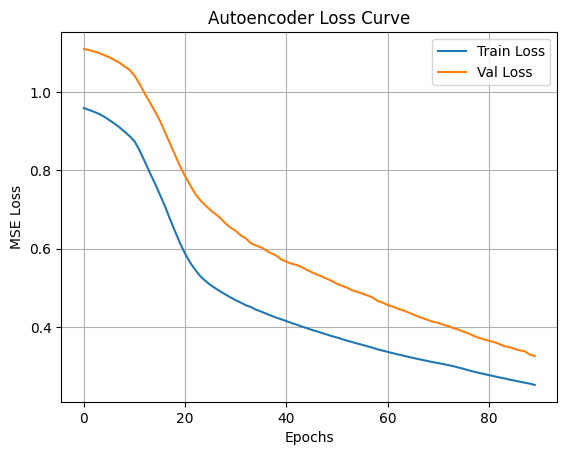

In [185]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Autoencoder Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()


In [186]:
# Create encoder model
encoder = Model(inputs=input_layer, outputs=bottleneck)

# Encode the data
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


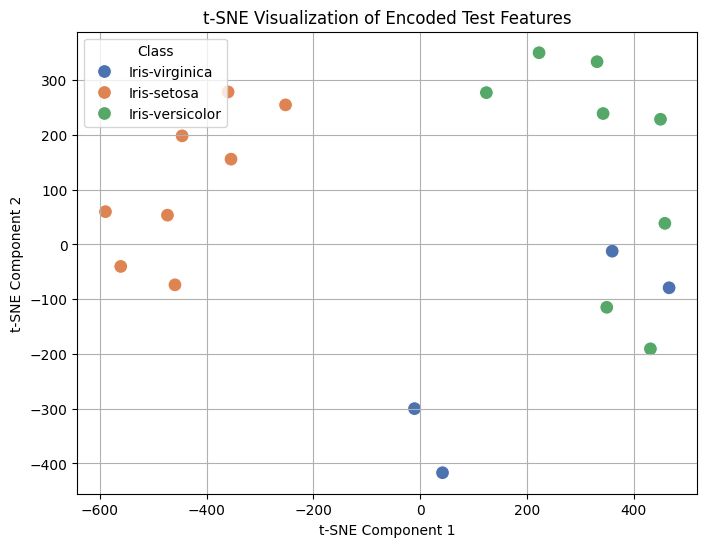

In [187]:

# Use the encoded test features
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_test_tsne = tsne.fit_transform(X_test_encoded)

# Convert y_true to class labels (not one-hot)
y_labels = label_encoder.inverse_transform(y_true)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_tsne[:, 0], y=X_test_tsne[:, 1], hue=y_labels, palette='deep', s=100)
plt.title("t-SNE Visualization of Encoded Test Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Class')
plt.grid(True)
plt.show()


FFNN

In [188]:

# Define deeper FFNN classifier
classifier = Sequential([
    Dense(64, activation='relu', input_shape=(encoding_dim,)),  # Wide first layer
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(3, activation='softmax')  # Output layer
])

# Compile the model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
history_classifier = classifier.fit(
    X_train_encoded, y_train,
    validation_data=(X_val_encoded, y_val),
    epochs=60,
    batch_size=8,
    verbose=1
)



Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2380 - loss: 1.0986 - val_accuracy: 0.3182 - val_loss: 1.0936
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3209 - loss: 1.0905 - val_accuracy: 0.3182 - val_loss: 1.0843
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3596 - loss: 1.0754 - val_accuracy: 0.3182 - val_loss: 1.0647
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3033 - loss: 1.0654 - val_accuracy: 0.5000 - val_loss: 1.0505
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5423 - loss: 1.0406 - val_accuracy: 0.5000 - val_loss: 1.0244
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5518 - loss: 1.0179 - val_accuracy: 0.5000 - val_loss: 0.9976
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6043 - loss: 0.9895 - val_accuracy: 0.5000 - val_loss: 0.9610
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5396 - loss: 0.9626 - val_accuracy: 0.5909 - val_los

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Test Accuracy (Autoencoder+FFNN): 0.8696
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         8
Iris-versicolor       1.00      0.62      0.77         8
 Iris-virginica       0.70      1.00      0.82         7

       accuracy                           0.87        23
      macro avg       0.90      0.88      0.86        23
   weighted avg       0.91      0.87      0.87        23



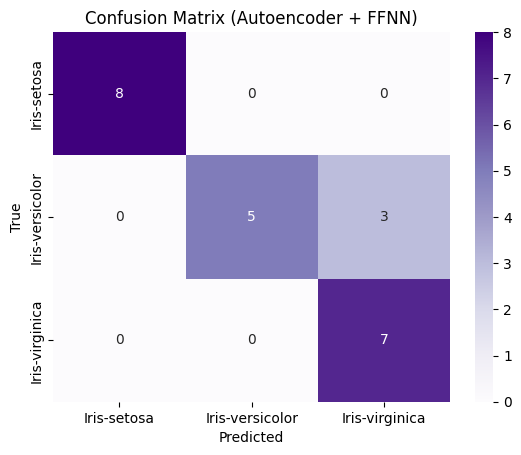

In [189]:
# Predict on encoded test data
y_pred_probs = classifier.predict(X_test_encoded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy (Autoencoder+FFNN): {acc:.4f}")

# Classification Report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, cmap='Purples', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Autoencoder + FFNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


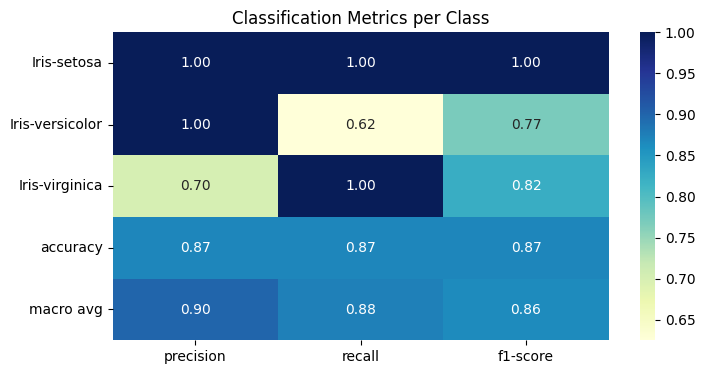

In [190]:

# Convert classification report to DataFrame
report = classification_report(y_true, y_pred, output_dict=True, target_names=label_encoder.classes_)
df_report = pd.DataFrame(report).transpose()

# Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Metrics per Class")
plt.show()
